## Preambule

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pth
import xarray as xr
from plotly.subplots import make_subplots
from tqdm import tqdm
import plotly.graph_objects as go
from pathlib import Path
from matplotlib import patches
from matplotlib import text as mtext
import math
import yaml

## Read config file

## Helper functions

In [13]:
def point(angle, value):
    unit_x = 0.5*np.cos((90-angle)/360*np.pi*2)
    unit_y = 0.5*np.sin((90-angle)/360*np.pi*2)
    return (unit_x*value+0.5, unit_y*value+0.5)

def point_ex(angle, value, dx):
    unit_x = 0.5*np.cos((90-angle)/360*np.pi*2)
    unit_y = 0.5*np.sin((90-angle)/360*np.pi*2)
    p = (unit_x*value+0.5, unit_y*value+0.5)
    pa = (p[0]+dx*(-unit_y), p[1]+dx*(unit_x))
    pb = (p[0]+dx*(unit_y), p[1]+dx*(-unit_x))
    return p, pa, pb

In [14]:
class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used


## Figure

Descriptions

In [15]:
names = [["Relative abatement index$^*$",
        #"Relative abatement index$^\u2020$",
        "Time scale of carbon price response$^*$", "Maximum mitigation speed", "Sensitivity primary energy mix", "Sensitivity demand"],
        ["Carbon intensity reduction$^\u2020$", "Energy intensity reduction$^\u2020$", "Carbon capture", r"Role of non-CO$_2$"+" abatement$^\u2020$"],
        ["Coal", "Oil", "Gas", "Solar", "Wind", "Biomass", "Nuclear"],
        ["Electricity\nin transport", "Electricity\nin industry", "Electricity\nin buildings", "Net electricity emissions", "Hydrogen use"],
        ["Cumulative costs per abatement value", "Transformation index$^\u2020$", "Demand shifts$^\u2020$"]]
expl = [[r"Relative change of CO$_2$ emissions",
        #r"Relative change of CO$_2$ emissions",
         r"Number of years before 66% reduction in CO$_2$ emissions",
         r"Maximum of CO$_2$ emission reductions"+"\n"+"in 5-year increments between 2020 and 2050",
         "Average (normalized) scenario variance"+"\n"+"in all primary energy carriers",
         "Average (normalized) scenario variance"+"\n"+"in final energy demand across end-use sectors"],
        ["Reduction in carbon intensity"+"\n"+r"(i.e., CO$_2$ emissions divided by final energy)",
         "Reduction in energy intensity"+"\n"+r"(i.e., final energy divided by GDP PPP)",
         "Carbon capture in the energy sector"+"\n"+"(including DAC, BECCS and fossil fuel\nuse with carbon capture)",
         r"Non-CO$_2$ emission reduction"+"\n"+r"divided by CO$_2$ emission reduction"+"\n"+"(only from the energy sector)"],
        ["Coal", "Oil", "Gas", "Solar", "Wind", "Biomass", "Nuclear"],
        ["Fraction electricity of total\nfinal energy use in transport",
         "Fraction electricity of total\nfinal energy use in industry",
         "Fraction electricity of total final energy use\nin the residential and commercial sector",
         r"CO$_2$ emissions from electricity generation",
         "Hydrogen use in the final energy\nmix as a fraction of the total"],
        ["Cumulative policy costs divided by the"+"\n"+"cumulative sum of carbon prices times"+"\n"+r"the marginal CO$_2$ emission reductions"+"\n"+"(over period 2020-2050)",
         "Sum of absolute changes in primary energy\ncarrier fractions",
         "Sum of absolute changes in final energy demand\nin end-use sectors"]]
names2 = [[r"$R_1$", r"$R_2$", r"$R_3$", r"$R_4$", r"$R_5$"],
        [r"$M_1$", r"$M_2$", r"$M_3$", r"$M_4$"],
        [r"$Es_1$", r"$Es_2$", r"$Es_3$", r"$Es_4$", r"$Es_5$", r"$Es_6$", r"$Es_7$"],
        [r"$Ed_1$", r"$Ed_2$", r"$Ed_3$",r"$Ed_4$", r"$Ed_5$"],
        [r"$C_1$", r"$C_2$", r"$C_3$"]]
vars = names
Cats = ["Responsiveness", "Mitigation strategies", "Energy supply", "Energy demand", "Costs and effort"]

Figure itself

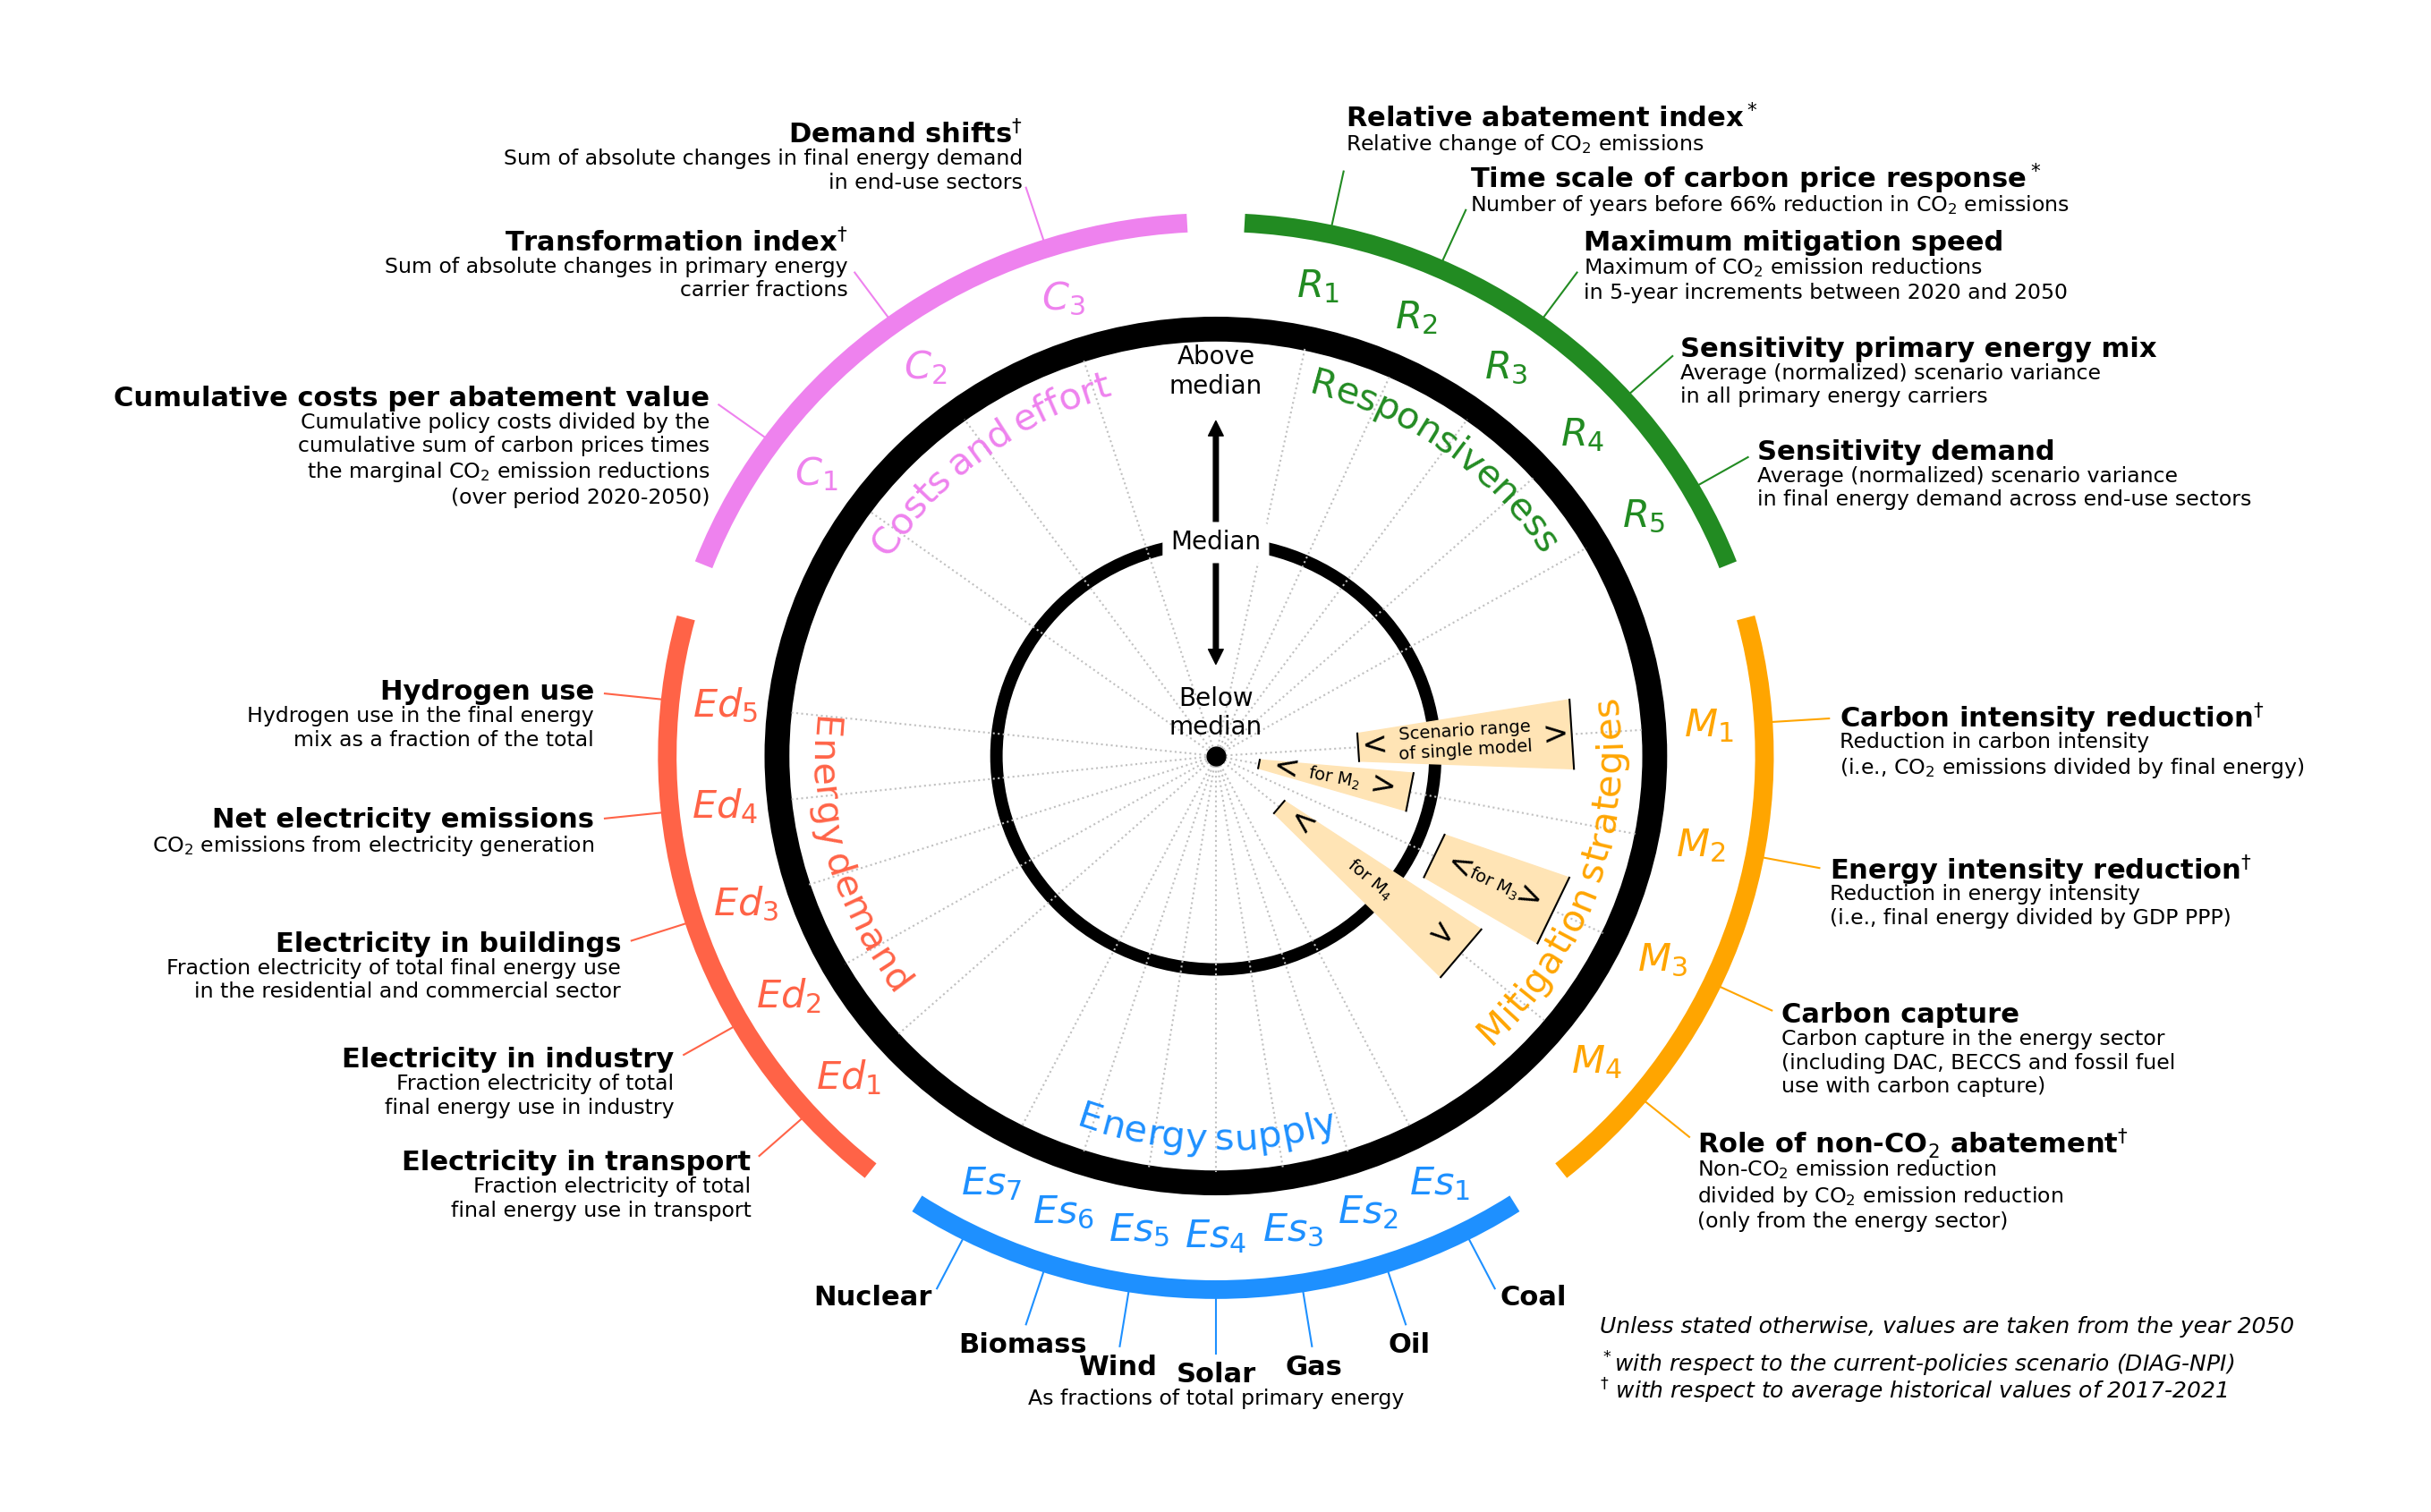

In [16]:
circle_border = plt.Circle((0.5, 0.5), 0.4, facecolor="white", edgecolor='k', lw=20)
circle_average = plt.Circle((0.5, 0.5), 0.2, facecolor='white', edgecolor='k', lw=10)
dr = 3
cols = ['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet']
incr = 360/len(vars)
da = (90 - 360/len(vars))
arc_outer_1 = pth.Arc((0.5, 0.5), 1, 1, theta1=da+0+dr, theta2=da+incr-dr, color=cols[0], lw=15)
arc_outer_5 = pth.Arc((0.5, 0.5), 1, 1, theta1=da+incr*4+dr, theta2=da+incr*5-dr, color=cols[1], lw=15)
arc_outer_4 = pth.Arc((0.5, 0.5), 1, 1, theta1=da+incr*3+dr, theta2=da+incr*4-dr, color=cols[2], lw=15)
arc_outer_3 = pth.Arc((0.5, 0.5), 1, 1, theta1=da+incr*2+dr, theta2=da+incr*3-dr, color=cols[3], lw=15)
arc_outer_2 = pth.Arc((0.5, 0.5), 1, 1, theta1=da+incr+dr, theta2=da+incr*2-dr, color=cols[4], lw=15)

fig, ax = plt.subplots(1, 1, figsize=(28, 17))
ax.add_patch(circle_border)
ax.add_patch(circle_average)
ax.add_patch(arc_outer_1)
ax.add_patch(arc_outer_2)
ax.add_patch(arc_outer_3)
ax.add_patch(arc_outer_4)
ax.add_patch(arc_outer_5)
ax.plot([0.5], [0.5], 'ko', ms=15, zorder=1e99)

# Actual data
time = 2050
for vl_i, vl in enumerate(vars):
        for var_i, var in enumerate(vl):
                pas = []
                pbs = []
                vals = []
                angle = (360/len(vars))*vl_i+((360/len(vars))/(len(vl)+1))*(var_i+1)
                p0 = point(angle, 0.39*2)
                ax.plot([0.5, p0[0]], [0.5, p0[1]], ':', c='silver', zorder=1)
                p0 = point(angle, 0.4*2+0.1)
                ax.text(p0[0], p0[1], names2[vl_i][var_i], fontsize=31, c=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][vl_i], ha='center', va='center')

                # Example ranges
                if var_i == 0 and vl_i == 1:
                        val = 0.26
                        _, pa1, pb1 = point_ex(angle, val, 0.4*val/len(vl))
                        val2 = 0.65
                        _, pa2, pb2 = point_ex(angle, val2, 0.4*val2/len(vl))
                        t1 = plt.Polygon([pa1, pb1, pb2, pa2], color="moccasin", alpha=1)
                        ax.add_patch(t1)
                        p, pa, pb = point_ex(angle, (val+val2)/2, 0.4*(val+val2)/2/len(vl))
                        ax.text(p[0], p[1], 'Scenario range\nof single model', fontsize=14, ha='center', va='center', rotation = 90-angle)
                        p, pa, pb = point_ex(angle, (val+0.03), 0.4*(val+0.03)/len(vl))
                        ax.text(p[0], p[1], '<', fontsize=25, ha='center', va='center', rotation = 90-angle)
                        p, pa, pb = point_ex(angle, (val2-0.03), 0.4*(val2-0.03)/len(vl))
                        ax.text(p[0], p[1], '>', fontsize=25, ha='center', va='center', rotation = 90-angle)
                        ax.plot([pa1[0], pb1[0]], [pa1[1], pb1[1]], c='black', zorder=1e9)
                        ax.plot([pa2[0], pb2[0]], [pa2[1], pb2[1]], c='black', zorder=1e9)
                if var_i in [1, 2, 3] and vl_i == 1:
                        v1 = [0.08, 0.44, 0.15][var_i-1]
                        _, pa1, pb1 = point_ex(angle, v1, 0.4*v1/len(vl))
                        v2 = [0.36, 0.68, 0.58][var_i-1]
                        _, pa2, pb2 = point_ex(angle, v2, 0.4*v2/len(vl))
                        t1 = plt.Polygon([pa1, pb1, pb2, pa2], color="moccasin", alpha=1)
                        ax.add_patch(t1)
                        p, pa, pb = point_ex(angle, (v1+v2)/2, 0.4*(v1+v2)/2/len(vl))
                        ax.text(p[0], p[1], [r'for M$_2$', r'for M$_3$', r'for M$_4$'][var_i-1], fontsize=14, ha='center', va='center', rotation = 90-angle) #'
                        p, pa, pb = point_ex(angle, (v1+0.05), 0.4*(v1+0.05)/len(vl))
                        ax.text(p[0], p[1], '<', fontsize=25, ha='center', va='center', rotation = 90-angle)
                        p, pa, pb = point_ex(angle, (v2-0.05), 0.4*(v2-0.05)/len(vl))
                        ax.text(p[0], p[1], '>', fontsize=25, ha='center', va='center', rotation = 90-angle)
                        ax.plot([pa1[0], pb1[0]], [pa1[1], pb1[1]], c='black', zorder=1e9)
                        ax.plot([pa2[0], pb2[0]], [pa2[1], pb2[1]], c='black', zorder=1e9)
                
                # Further explanations
                p0 = point(angle, 0.4*2+0.2)
                p1 = point(angle, 0.4*2+0.32)
                p2 = point(angle, 0.4*2+0.34)
                if angle <= 160:
                        a = 'left'
                        dy = 0
                        if vl_i == 0:
                                dy = [0.10, 0.08, 0.08, 0.06, 0.06][var_i]-0.06#0.10-angle**0.125 * 0.06
                elif angle <= 200:
                        a = 'center'
                        dy = -0.01
                else:
                        a = 'right'
                        dy = 0
                if vl_i == 4:
                        dy = [0.10, 0.08, 0.06][::-1][var_i]-0.06#0.10-angle**0.125 * 0.06
                ax.plot([p0[0], p1[0]], [p0[1], p1[1]], c=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][vl_i])
                ax.text(p2[0], p2[1]+dy, names[vl_i][var_i].replace('\n', ' '), fontsize=22, ha=a, va='center', weight='bold')
                if vl_i != 2:
                        ax.text(p2[0], p2[1]-0.013+dy, expl[vl_i][var_i], fontsize=17, ha=a, va='top')
                elif var_i == 3:
                        ax.text(p2[0], p2[1]-0.023, "As fractions of total primary energy", fontsize=17, ha=a, va='top')

ax.text(0.5, 0.54, 'Below\nmedian', fontsize=20, ha='center', va='center', zorder=1e999)
ax.text(0.5, 0.7, 'Median', fontsize=20, ha='center', va='center', zorder=1e999, bbox=dict(boxstyle="round",
                   ec='white',
                   fc='white',
                   ))
ax.text(0.5, 0.86, 'Above\nmedian', fontsize=20, ha='center', va='center', zorder=1e999)

dr = 0.4
r0 = 0
for c_i, c in enumerate(Cats):
        ph = [0.03, 0.13, 1.78, 1.36, 0.43][c_i]*np.pi

        if c_i == 0 or c_i == 4:
                text = CurvedText(
                x = 0.36*np.cos(np.arange(r0*np.pi-dr*np.pi+ph, r0*np.pi+dr*np.pi+ph, 0.001)[::-1])+0.5,
                y = 0.36*np.sin(np.arange(r0*np.pi-dr*np.pi+ph, r0*np.pi+dr*np.pi+ph, 0.001)[::-1])+0.5,
                text=c,
                color=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][c_i],
                fontsize=30,
                ha='center',
                va = 'center',
                axes = ax,
                )
        if c_i == 1 or c_i == 2 or c_i == 3:
                text = CurvedText(
                x = 0.36*np.cos(np.arange(r0*np.pi-dr*np.pi+ph, r0*np.pi+dr*np.pi+ph, 0.001))+0.5,
                y = 0.36*np.sin(np.arange(r0*np.pi-dr*np.pi+ph, r0*np.pi+dr*np.pi+ph, 0.001))+0.5,
                text=c,
                color=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][c_i],
                fontsize=30,
                ha='center',
                va = 'center',
                axes = ax,
                )

ax.annotate("", xy=(0.5, 0.82), xytext=(0.5, 0.7),
            arrowprops=dict(shrink=0.05, facecolor='k'))
ax.annotate("", xy=(0.5, 0.58), xytext=(0.5, 0.7),
            arrowprops=dict(shrink=0.05, facecolor='k'))

ax.text(0.85, -0.07, '$^*$with respect to the current-policies scenario (DIAG-NPI)', fontsize=18, ha='left', va='center', zorder=1e999, style='italic')
ax.text(0.85, -0.095, '$^\u2020$ with respect to average historical values of 2017-2021', fontsize=18, ha='left', va='center', zorder=1e999, style='italic')
ax.text(0.85, -0.035, 'Unless stated otherwise, values are taken from the year 2050', fontsize=18, ha='left', va='center', zorder=1e999, style='italic')

# Other
ax.set_xlim([-0.6, 1.6])
ax.set_ylim([-0.2, 1.2])
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig(settings['paths']['figures']+"Figure_1.png", dpi = 400, bbox_inches = "tight")